libraries and dependenceis

In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from datasets import load_dataset
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
from collections import Counter

c:\Users\assas\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


dataset loading and preprocessing

In [2]:
dataset = load_dataset("ylecun/mnist")
tensor_transform = transforms.ToTensor()


def transform_example(example):
    image = tensor_transform(example['image'])  
    return {'image': image, 'label': example['label']}

dataset['train'] = dataset['train'].map(transform_example)
dataset['test'] = dataset['test'].map(transform_example)


dataset.set_format(type='torch', columns=['image', 'label'])


train_loader = DataLoader(dataset['train'], batch_size=32, shuffle=False)
test_loader = DataLoader(dataset['test'], batch_size=32, shuffle=False)


for batch in train_loader:
    images = batch['image']
    labels = batch['label']
    print(f"Image batch shape: {images.shape}")  
    print(f"Label batch shape: {labels.shape}")  
    break

Image batch shape: torch.Size([32, 1, 28, 28])
Label batch shape: torch.Size([32])


dataset visualization

(60000, 784)
(60000,)


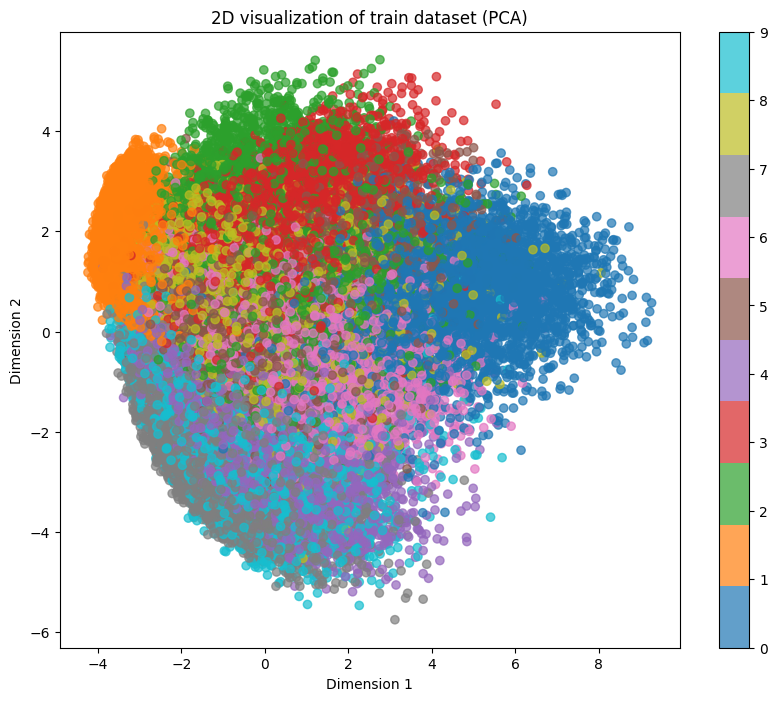

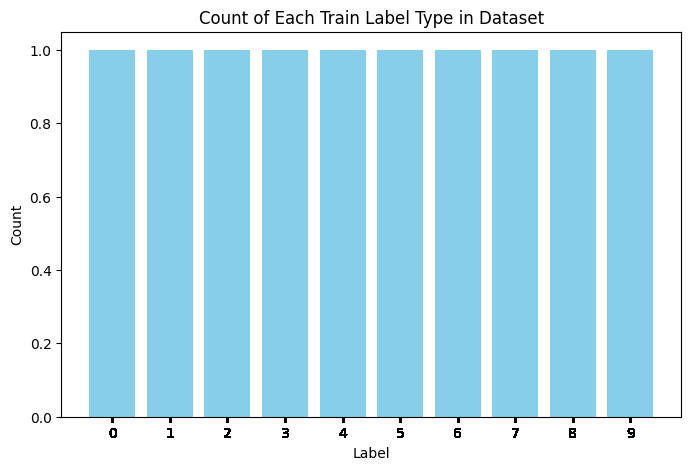

(10000, 784)
(10000,)


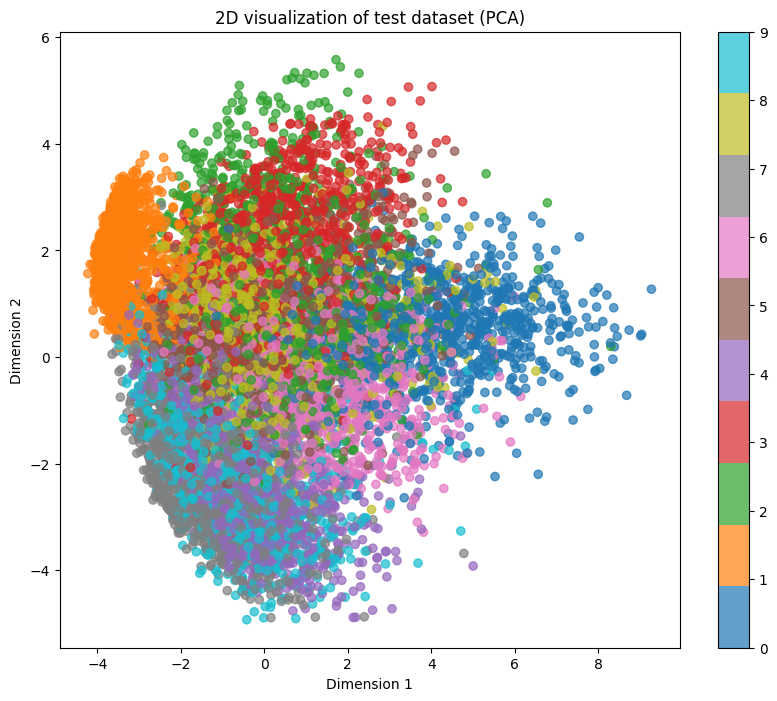

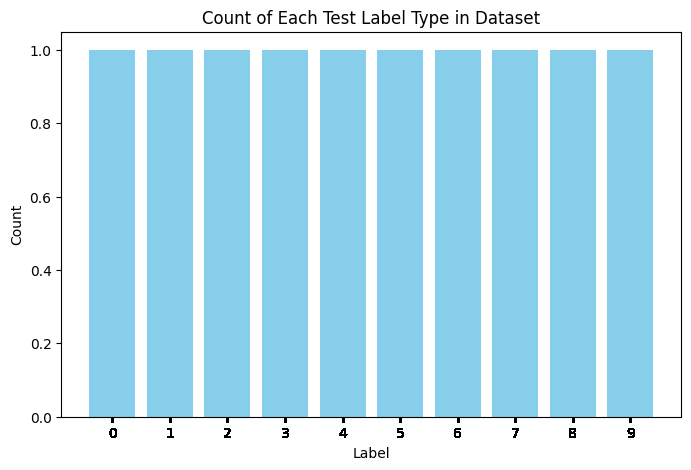

In [3]:

images = np.array([np.array(sample['image']).flatten() for sample in dataset['train']])
labels = np.array([sample['label'] for sample in dataset['train']])

print(images.shape)  
print(labels.shape)  


pca = PCA(n_components=2)
features_2d = pca.fit_transform(images)


plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.title('2D visualization of train dataset (PCA)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


labels = dataset['train']['label']


label_counts = Counter(labels)


label_names = list(label_counts.keys())
counts = list(label_counts.values())

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(label_names, counts, color='skyblue')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Each Train Label Type in Dataset')
plt.xticks(label_names)  
plt.show()


images = np.array([np.array(sample['image']).flatten() for sample in dataset['test']])
labels = np.array([sample['label'] for sample in dataset['test']])

print(images.shape)  
print(labels.shape)  


pca = PCA(n_components=2)
features_2d = pca.fit_transform(images)


plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.title('2D visualization of test dataset (PCA)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


labels = dataset['test']['label']


label_counts = Counter(labels)


label_names = list(label_counts.keys())
counts = list(label_counts.values())

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(label_names, counts, color='skyblue')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Each Test Label Type in Dataset')
plt.xticks(label_names)  
plt.show()

Autoencoder (epochs=10)

Epoch 1/10, Loss: 0.039298
Epoch 2/10, Loss: 0.028195
Epoch 3/10, Loss: 0.022494
Epoch 4/10, Loss: 0.017744
Epoch 5/10, Loss: 0.013825
Epoch 6/10, Loss: 0.011114
Epoch 7/10, Loss: 0.009814
Epoch 8/10, Loss: 0.008907
Epoch 9/10, Loss: 0.008201
Epoch 10/10, Loss: 0.007676


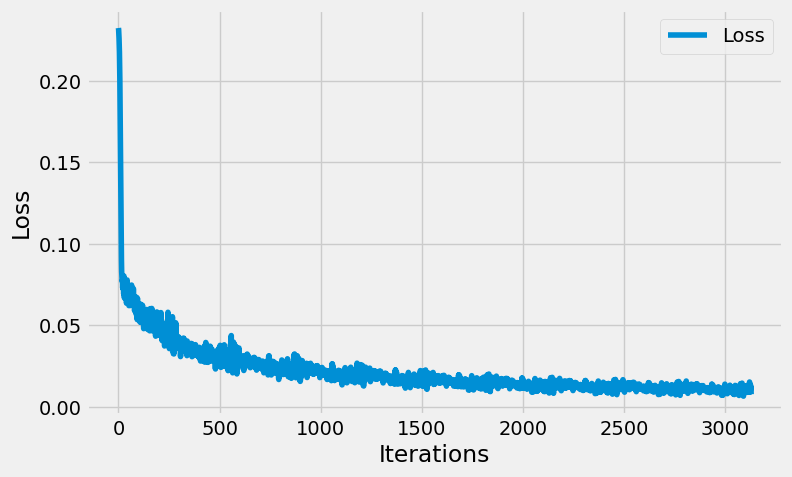

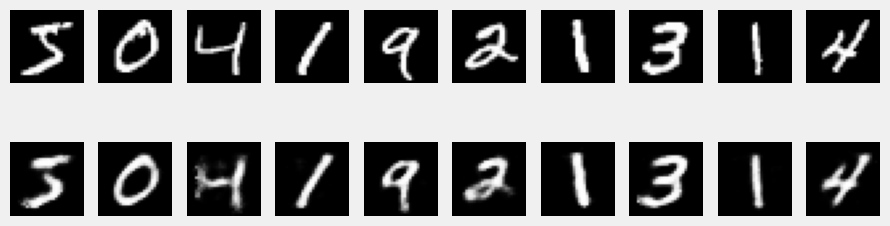

Auto-encoder model: 
AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)
Total parameters: 218192
Trainable parameters: 218192


In [4]:

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.decoder = nn.Sequential(
            
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
model = AE()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

epochs = 10
outputs = []
losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    for batch in test_loader:
        images = batch['image'].to(device)
        images = images.view(-1, 28 * 28).to(device)
        reconstructed = model(images)
        loss = loss_function(reconstructed, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    outputs.append((epoch, images, reconstructed))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.eval()
dataiter = iter(train_loader)
batch = next(dataiter)

images = batch['image'].view(-1, 28 * 28).to(device)
reconstructed = model(images)

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 3))
for i in range(10):
    axes[0, i].imshow(images[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
plt.show()


print('Auto-encoder model: ')
model=AE()
print(model)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Autoencoder

Epoch 1/20, Loss: 0.041654
Epoch 2/20, Loss: 0.029341
Epoch 3/20, Loss: 0.022109
Epoch 4/20, Loss: 0.017421
Epoch 5/20, Loss: 0.014095
Epoch 6/20, Loss: 0.011827
Epoch 7/20, Loss: 0.009969
Epoch 8/20, Loss: 0.008821
Epoch 9/20, Loss: 0.008133
Epoch 10/20, Loss: 0.007541
Epoch 11/20, Loss: 0.007128
Epoch 12/20, Loss: 0.006714
Epoch 13/20, Loss: 0.006418
Epoch 14/20, Loss: 0.006136
Epoch 15/20, Loss: 0.005911
Epoch 16/20, Loss: 0.005755
Epoch 17/20, Loss: 0.005579
Epoch 18/20, Loss: 0.005381
Epoch 19/20, Loss: 0.005164
Epoch 20/20, Loss: 0.005035


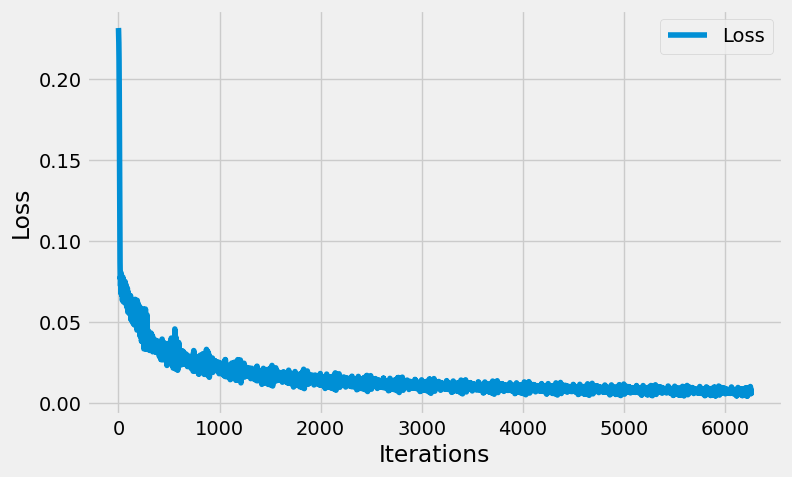

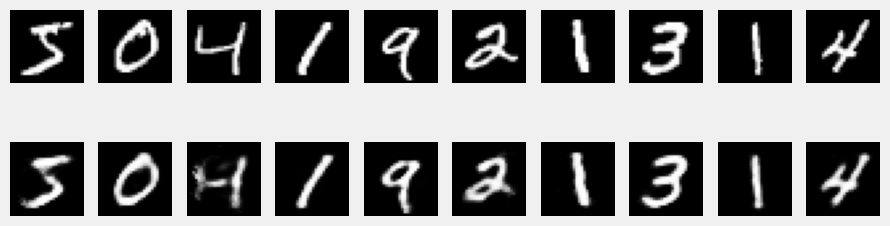

In [5]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.decoder = nn.Sequential(
            
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    
model = AE()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

epochs = 20
outputs = []
losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    for batch in test_loader:
        images = batch['image'].to(device)
        images = images.view(-1, 28 * 28).to(device)
        reconstructed = model(images)
        loss = loss_function(reconstructed, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    outputs.append((epoch, images, reconstructed))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.eval()
dataiter = iter(train_loader)
batch = next(dataiter)

images = batch['image'].view(-1, 28 * 28).to(device)
reconstructed = model(images)

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 3))
for i in range(10):
    axes[0, i].imshow(images[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
plt.show()

feature extraction (embeddings of autoencoder)

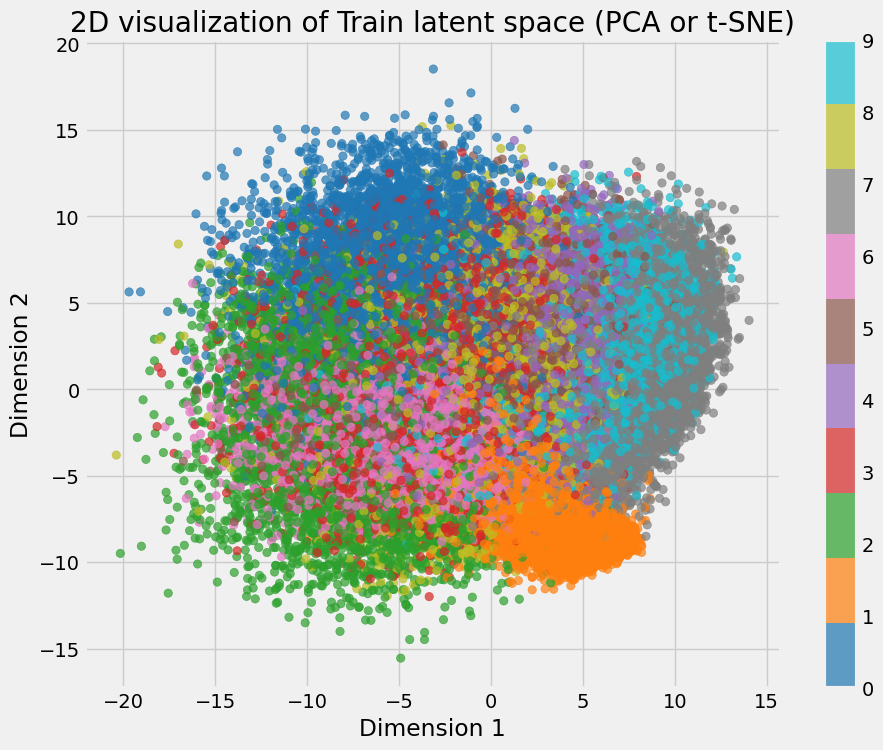

In [6]:
model.eval()  
features = []

with torch.no_grad():
    for batch in train_loader:
        images = batch['image'].to(device)
        images = images.view(-1, 28*28).to(device)  
        encoded = model.encoder(images)  
        features.append(encoded.cpu().numpy())  

features_graph = np.concatenate(features, axis=0)

pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_graph)
plt.figure(figsize=(10,8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=dataset['train']['label'], cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.title('2D visualization of Train latent space (PCA or t-SNE)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

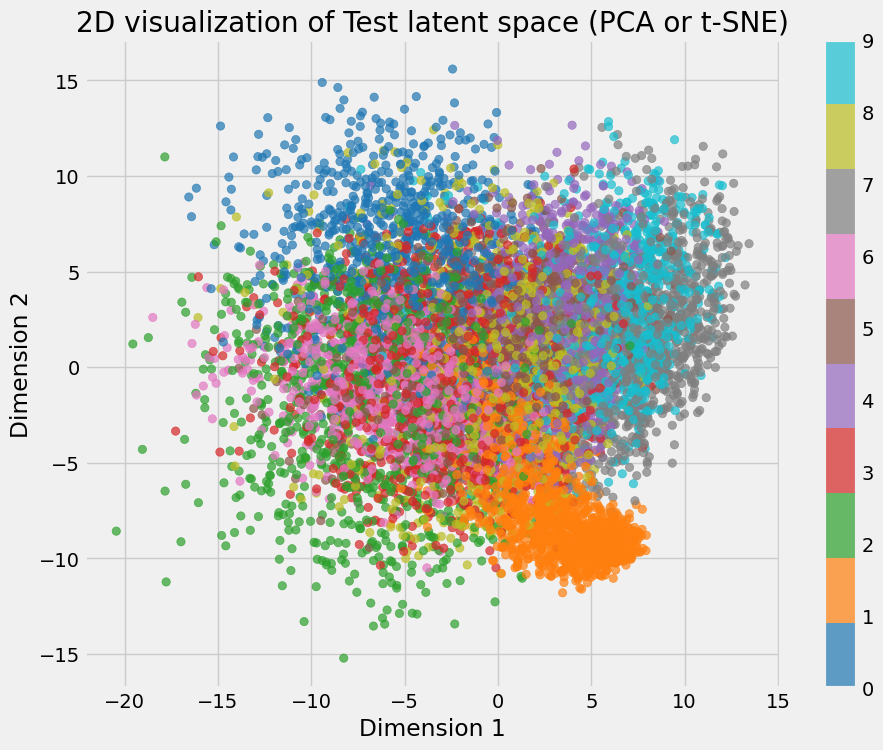

In [7]:
model.eval()  
features_test = []

with torch.no_grad():
    for batch in test_loader:
        images = batch['image'].to(device)
        images = images.view(-1, 28*28).to(device)  
        encoded = model.encoder(images)  
        features_test.append(encoded.cpu().numpy())  


features_test_graph = np.concatenate(features_test, axis=0)

pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_test_graph)
plt.figure(figsize=(10,8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=dataset['test']['label'], cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.title('2D visualization of Test latent space (PCA or t-SNE)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [8]:
features_test = [emb for emb in features_test if len(emb) == 32]
features_test = np.array(features_test, dtype=np.float32)

evaluation with custom cluster algorithm

In [9]:
features_tensor = torch.tensor(features_graph, dtype=torch.float32).to(device)  
features_test_tensor = torch.tensor(features_test_graph, dtype=torch.float32).to(device)  

class CustomClusterer(nn.Module):
    def __init__(self, n_clusters=10, feature_dim=features_tensor.shape[1]):
        super().__init__()
        # indices = np.random.choice(features_tensor.shape[0], n_clusters, replace=False)
        # init_centers = features_tensor[indices]
        # self.cluster_centers = nn.Parameter(init_centers)  

        mean = torch.mean(features_tensor, dim=0)
        dists = torch.norm(features_tensor - mean, dim=1)
        _, top_indices = torch.topk(dists, n_clusters)
        init_centers = features_tensor[top_indices]
        self.cluster_centers = nn.Parameter(init_centers)

        
        
    def forward(self, x):
        x_exp = x.unsqueeze(1)  
        centers_exp = self.cluster_centers.unsqueeze(0)  
        dist = torch.sum((x_exp - centers_exp)**2, dim=2)  
        soft_assign = torch.softmax(-dist, dim=1)
        return soft_assign, dist

def train_custom_clusterer(features, features_test, n_clusters=10, epochs=100, lr=0.1):
    model = CustomClusterer(n_clusters=n_clusters, feature_dim=features.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    features = features.to(device)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        soft_assign, dist = model(features)
        loss = torch.sum(soft_assign * dist) / features.shape[0]
        
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
    
    
    with torch.no_grad():
        soft_assign, _ = model(features)
        cluster_labels = torch.argmax(soft_assign, dim=1).cpu().numpy()
        soft_assign, _ = model(features_test)
        cluster_labels_test = torch.argmax(soft_assign, dim=1).cpu().numpy()
    
    return model.cluster_centers.detach().cpu().numpy(), cluster_labels, cluster_labels_test


cluster_centers, cluster_labels, cluster_labels_test = train_custom_clusterer(features_tensor, features_test_tensor, n_clusters=10, epochs=200, lr=0.1)

print("Cluster centers shape:", cluster_centers.shape)
print("Sample cluster labels:", cluster_labels[:20])

Epoch 10/200, Loss: 694.5228
Epoch 20/200, Loss: 506.4955
Epoch 30/200, Loss: 381.8743
Epoch 40/200, Loss: 302.0769
Epoch 50/200, Loss: 257.0800
Epoch 60/200, Loss: 232.7169
Epoch 70/200, Loss: 221.0606
Epoch 80/200, Loss: 215.6702
Epoch 90/200, Loss: 212.6189
Epoch 100/200, Loss: 210.4702
Epoch 110/200, Loss: 208.7849
Epoch 120/200, Loss: 207.3183
Epoch 130/200, Loss: 205.9847
Epoch 140/200, Loss: 204.7411
Epoch 150/200, Loss: 203.5678
Epoch 160/200, Loss: 202.4028
Epoch 170/200, Loss: 201.2480
Epoch 180/200, Loss: 200.2247
Epoch 190/200, Loss: 199.4069
Epoch 200/200, Loss: 198.7497
Cluster centers shape: (10, 64)
Sample cluster labels: [0 0 5 1 9 3 1 4 1 9 0 0 8 7 1 2 3 4 7 2]


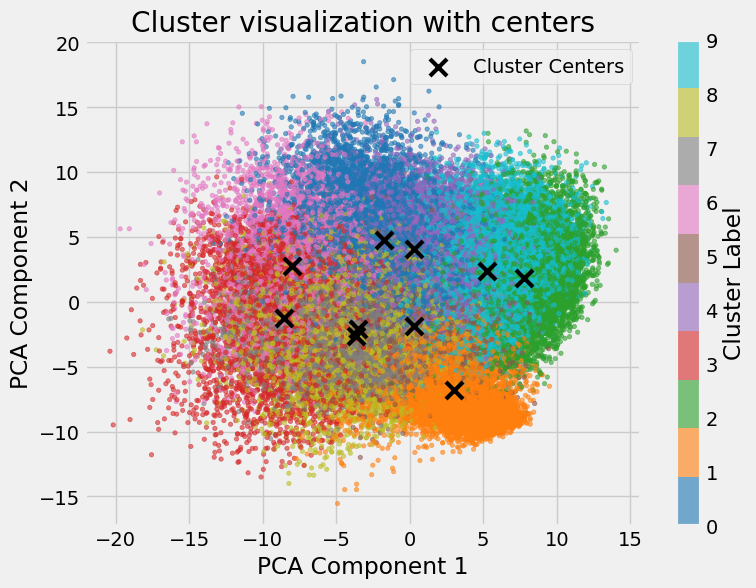

Silhouette Score: 0.0971
Davies-Bouldin Index: 2.4624
Calinski-Harabasz Index: 2919.7973


In [10]:
y_pred=cluster_labels
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_graph)
centers_2d = pca.transform(cluster_centers)  


plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=cluster_labels, cmap='tab10', s=10, alpha=0.6)


plt.scatter(centers_2d[:, 0], centers_2d[:, 1], marker='x', s=150, c='black', label='Cluster Centers', linewidths=3)

plt.title("Cluster visualization with centers")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label="Cluster Label")
plt.legend()
plt.show()


sil_score = silhouette_score(features_graph, y_pred)
db_index = davies_bouldin_score(features_graph, y_pred)
ch_index = calinski_harabasz_score(features_graph, y_pred)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Calinski-Harabasz Index: {ch_index:.4f}")



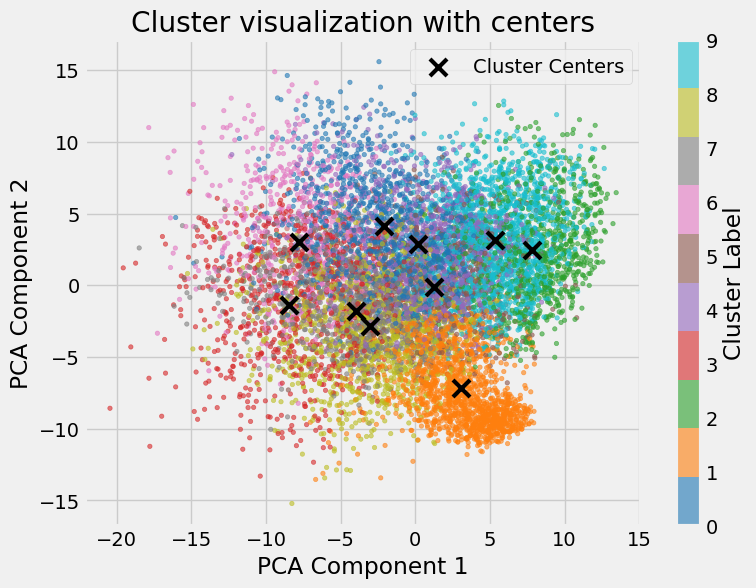

Silhouette Score: 0.0979
Davies-Bouldin Index: 2.4755
Calinski-Harabasz Index: 490.7075


In [11]:
y_pred=cluster_labels_test
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_test_graph)
centers_2d = pca.transform(cluster_centers)  


plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=cluster_labels_test, cmap='tab10', s=10, alpha=0.6)


plt.scatter(centers_2d[:, 0], centers_2d[:, 1], marker='x', s=150, c='black', label='Cluster Centers', linewidths=3)

plt.title("Cluster visualization with centers")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label="Cluster Label")
plt.legend()
plt.show()


sil_score = silhouette_score(features_test_graph, y_pred)
db_index = davies_bouldin_score(features_test_graph, y_pred)
ch_index = calinski_harabasz_score(features_test_graph, y_pred)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Calinski-Harabasz Index: {ch_index:.4f}")



KMEANS

evaluation with kmeans (with autoencoder embeddings)

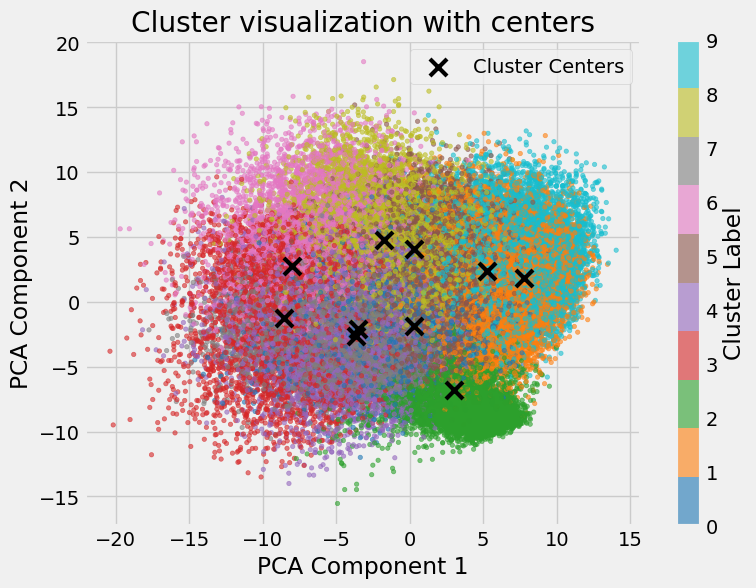

Silhouette Score: 0.0944
Davies-Bouldin Index: 2.4995
Calinski-Harabasz Index: 2980.4283


In [12]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(features_graph)

y_pred=kmeans.labels_
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_graph)
centers_2d = pca.transform(cluster_centers)  


plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=y_pred, cmap='tab10', s=10, alpha=0.6)


plt.scatter(centers_2d[:, 0], centers_2d[:, 1], marker='x', s=150, c='black', label='Cluster Centers', linewidths=3)

plt.title("Cluster visualization with centers")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label="Cluster Label")
plt.legend()
plt.show()


sil_score = silhouette_score(features_graph, y_pred)
db_index = davies_bouldin_score(features_graph, y_pred)
ch_index = calinski_harabasz_score(features_graph, y_pred)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Calinski-Harabasz Index: {ch_index:.4f}")

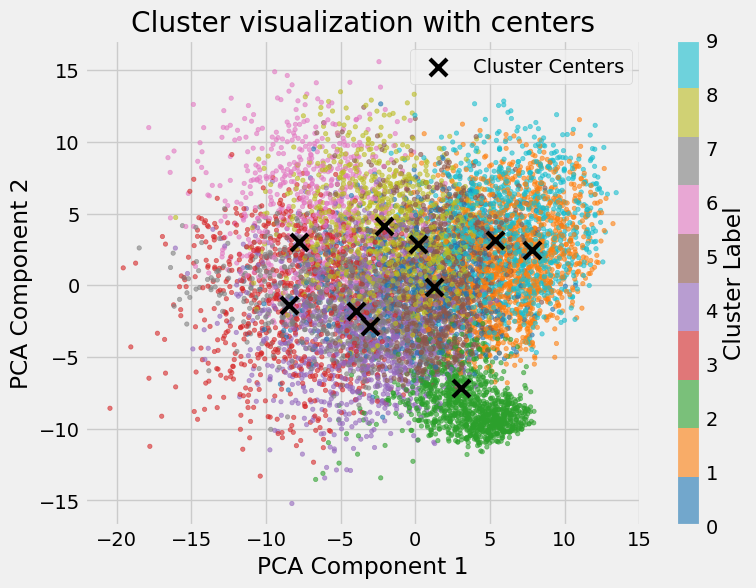

Silhouette Score: 0.0949
Davies-Bouldin Index: 2.5091
Calinski-Harabasz Index: 499.0422


In [13]:
test_clusters = kmeans.predict(features_test_graph)

y_pred=test_clusters
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_test_graph)
centers_2d = pca.transform(cluster_centers)  


plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=y_pred, cmap='tab10', s=10, alpha=0.6)


plt.scatter(centers_2d[:, 0], centers_2d[:, 1], marker='x', s=150, c='black', label='Cluster Centers', linewidths=3)

plt.title("Cluster visualization with centers")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label="Cluster Label")
plt.legend()
plt.show()


sil_score = silhouette_score(features_test_graph, y_pred)
db_index = davies_bouldin_score(features_test_graph, y_pred)
ch_index = calinski_harabasz_score(features_test_graph, y_pred)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Calinski-Harabasz Index: {ch_index:.4f}")

autoencoder model architecture and paremeters

In [14]:
print('Auto-encoder model: ')
model=AE()
print(model)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

print()
print('CustomClusterer model: ')
model=CustomClusterer()
print(model)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

print()
print(kmeans)

Auto-encoder model: 
AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)
Total parameters: 218192
Trainable parameters: 218192

CustomClusterer model: 
CustomClusterer()
Total parameters: 640
Trainable parameters: 640

KMeans(n_clusters=10, random_state=42)
